In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot

2024-06-12 23:13:23.645423: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 23:13:23.646902: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 23:13:23.673445: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 23:13:23.673974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 23:13:24.159402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# Function we want to learn
def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))

def f(x):

    # return np.sin(2 * np.pi * x)

    alpha_s_scale = alpha_s(x * 500) # GeV
    C_F = 4/3
    C_A = 3

    return -(alpha_s_scale * C_F / (1 * np.pi)) * np.log(x ) / x


# Model

In [3]:
# Custom Loss

def custom_loss(y_true, y_pred, Lambda, x):


    # We want to match the prediction to the true value only if x > Lambda
    condition = tf.cast(x > Lambda, tf.float32)
    loss = condition * tf.square(y_true - y_pred) / (100 * alpha_s(x * 500))**2 



    # If x < Lambda, we want to [do nothing, let extrapolate]
    loss += (1 - condition) * tf.square(y_true - y_pred) / (alpha_s(x * 500))**2 

    return tf.reduce_mean(loss)


In [4]:
def initialize_model():

    input_x = keras.Input(shape=(1,), name='x')
    input_Lambda = keras.Input(shape=(1,), name='Lambda')
    concat = layers.Concatenate()([input_x, input_Lambda])


    dense = layers.Dense(64, activation='relu')(concat)
    dense = layers.Dense(64, activation='relu')(dense)
    output = layers.Dense(1)(dense)

    model = keras.Model(inputs=[input_x, input_Lambda], outputs=output)

    # model.compile(optimizer='adam', loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, input_Lambda, input_x))

    return model


# Train

In principle, we should write a training loop to continuously resample the function and sample Lambda. But out of laziness we will just pre-generate.

In [5]:
def train(model):
    batch_size = 512*8
    epochs = 2500
    optimizer = keras.optimizers.Adam(lr = 0.01)

    losses = []

    for epoch in range(epochs):
        x = np.random.uniform(0.01, 1, (batch_size, 1))
        Lambda = np.random.uniform(0.01, 1, (batch_size, 1))
        y = f(x)

        with tf.GradientTape() as tape:
            y_pred = model([x, Lambda])
            loss = custom_loss(y, y_pred, Lambda, x)

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        losses.append(loss.numpy())

        print(f"Epoch {epoch} Loss {loss.numpy()}")




models = []
for i in range(10):
    model = initialize_model()
    train(model)
    models.append(model)

        

Epoch 0 Loss 129197792.0
Epoch 1 Loss 3341732352.0
Epoch 2 Loss 440685312.0
Epoch 3 Loss 7291801088.0
Epoch 4 Loss 4707899904.0
Epoch 5 Loss 4439006720.0
Epoch 6 Loss 889589312.0
Epoch 7 Loss 98931482624.0
Epoch 8 Loss 4960083456.0
Epoch 9 Loss 5242974208.0
Epoch 10 Loss 48000864256.0
Epoch 11 Loss 5694342656.0
Epoch 12 Loss 4799756949782528.0
Epoch 13 Loss 361961888.0
Epoch 14 Loss 513788416.0
Epoch 15 Loss 270598656.0
Epoch 16 Loss 324702528.0
Epoch 17 Loss 4879102976.0
Epoch 18 Loss 2941864960.0
Epoch 19 Loss 8905321472.0
Epoch 20 Loss 7341537280.0
Epoch 21 Loss 114301800.0
Epoch 22 Loss 118908192.0
Epoch 23 Loss 255743008.0
Epoch 24 Loss 12732632064.0
Epoch 25 Loss 1631880960.0
Epoch 26 Loss 449277001728.0
Epoch 27 Loss 620863168.0
Epoch 28 Loss 18684489728.0
Epoch 29 Loss 2535590400.0
Epoch 30 Loss 8999040000.0
Epoch 31 Loss 75132125184.0
Epoch 32 Loss 39235371008.0
Epoch 33 Loss 1233733504.0
Epoch 34 Loss 196018560.0
Epoch 35 Loss 100498744.0
Epoch 36 Loss 2037759488.0
Epoch 37 L

Epoch 2487 Loss 238442790912.0
Epoch 2488 Loss 4102584832.0
Epoch 2489 Loss 168535792.0
Epoch 2490 Loss 381271104.0
Epoch 2491 Loss 2911530496.0
Epoch 2492 Loss 18439114752.0
Epoch 2493 Loss 11079861248.0
Epoch 2494 Loss 150997280.0
Epoch 2495 Loss 1690471552.0
Epoch 2496 Loss 5589954048.0
Epoch 2497 Loss 26534680576.0
Epoch 2498 Loss 14566937600.0
Epoch 2499 Loss 797230336.0
Epoch 0 Loss 95067545600.0
Epoch 1 Loss 2509257310208.0
Epoch 2 Loss 258630640.0
Epoch 3 Loss 32575670272.0
Epoch 4 Loss 793758080.0
Epoch 5 Loss 192600539136.0
Epoch 6 Loss 5504727513038848.0
Epoch 7 Loss 5233375744.0
Epoch 8 Loss 9086356480.0
Epoch 9 Loss 3060021248.0
Epoch 10 Loss 47286824960.0
Epoch 11 Loss 475625408.0
Epoch 12 Loss 618956288.0
Epoch 13 Loss 622325888.0
Epoch 14 Loss 1957048320.0
Epoch 15 Loss 3354345728.0
Epoch 16 Loss 3671433984.0
Epoch 17 Loss 1686439040.0
Epoch 18 Loss 403996246016.0
Epoch 19 Loss 365599360.0
Epoch 20 Loss 44996653056.0
Epoch 21 Loss 524543488.0
Epoch 22 Loss 1335480960.0


KeyboardInterrupt: 

/tmp/ipykernel_86734/1328965480.py:5: RuntimeWarning: divide by zero encountered in log
  return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))
/tmp/ipykernel_86734/1328965480.py:15: RuntimeWarning: divide by zero encountered in log
  return -(alpha_s_scale * C_F / (1 * np.pi)) * np.log(x ) / x
/tmp/ipykernel_86734/1328965480.py:15: RuntimeWarning: invalid value encountered in multiply
  return -(alpha_s_scale * C_F / (1 * np.pi)) * np.log(x ) / x


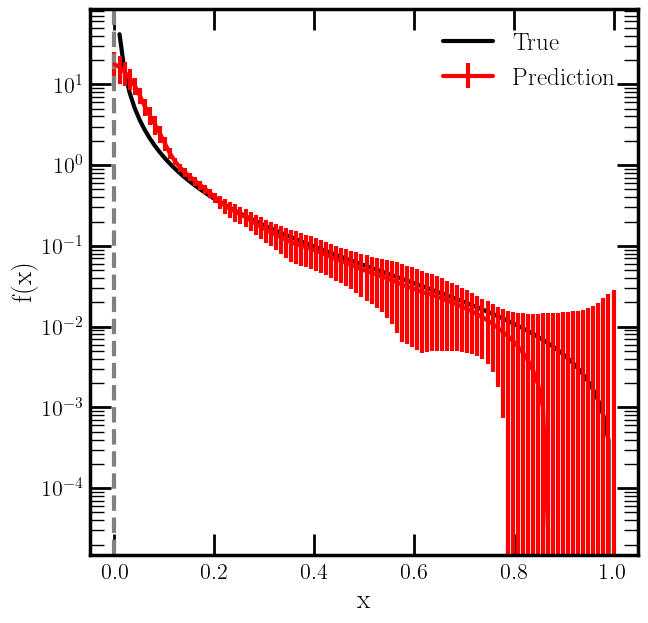

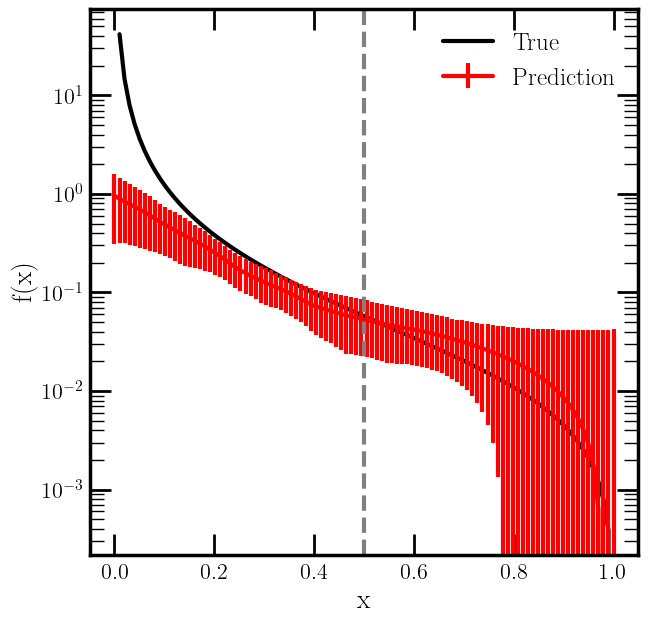

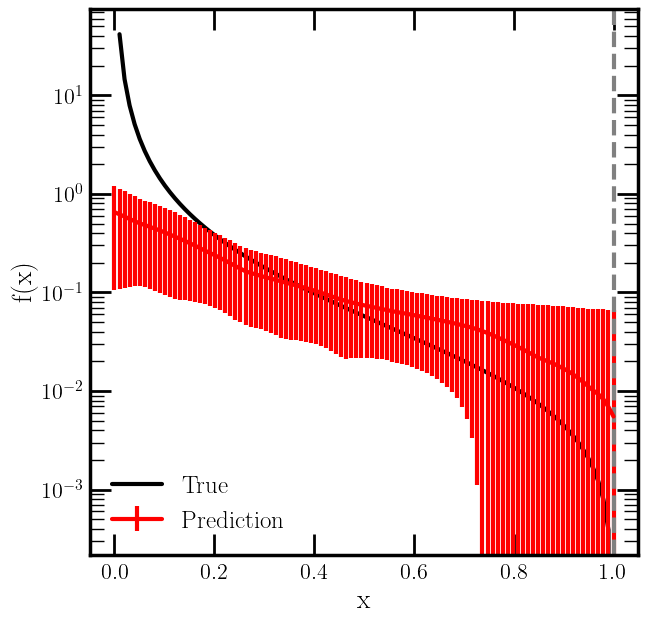

In [ ]:
x_test = np.linspace(0, 1, 100)
y_test = f(x_test)  

Lambdas_test = [0, 0.25, 0.5, 0.75, 1]

for Lambda_test in Lambdas_test:

    y_preds = [model([x_test, np.ones_like(x_test) * Lambda_test]) for model in models]
    y_preds = np.array(y_preds)
    y_pred = np.mean(y_preds, axis=0)
    y_std = np.std(y_preds, axis=0)


    fig, ax = newplot("full")
    ax.plot(x_test, y_test, label='True', color = 'black')
    plt.errorbar(x_test, y_pred[:,0], yerr=y_std[:,0], label='Prediction', color='red')
    plt.axvline(Lambda_test, color='grey', linestyle='--')

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.yscale('log')
    plt.legend()
